In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os



In [ ]:
# --- 1. Define File Paths ---
# Make sure to change this to the actual path where you unzipped the data
BASE_DIR = r"C:\Users\naqsh\OneDrive\Desktop\pneumonia-prediction-analysis" 
b
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- 2. Set Model Parameters ---
# We'll start with 150x150 images. 
# This is a good balance between detail and training speed.
IMG_SIZE = (150, 150) 
BATCH_SIZE = 32 # Process 32 images at a time

In [3]:
# --- 3. Create Data Generators (with validation split) ---

# We will split the 'train' folder into training (80%) and validation (20%)
# We must set a 'seed' (any number) to ensure the split is the same every time
# and that there is NO overlap between training and validation images.

IMG_SIZE = (150, 150) # Make sure this is defined (should be in cell 1)
BATCH_SIZE = 32      # Make sure this is defined (should be in cell 1)

# Create the TRAINING dataset (80% of the 'train' folder)
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2, # Create a 20% validation split
    subset='training',      # Specify this is the training subset
    seed=1337             # Use a seed for a reproducible split
)

# Create the VALIDATION dataset (20% of the 'train' folder)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, # We use the SAME directory
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,        # No need to shuffle validation data
    validation_split=0.2, # Use the same 20% split
    subset='validation',    # Specify this is the validation subset
    seed=1337             # Use the SAME seed to ensure no overlap
)

# Create the TEST dataset (this remains the same)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- 4. Verify Class Names ---
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.
Classes found: ['NORMAL', 'PNEUMONIA']


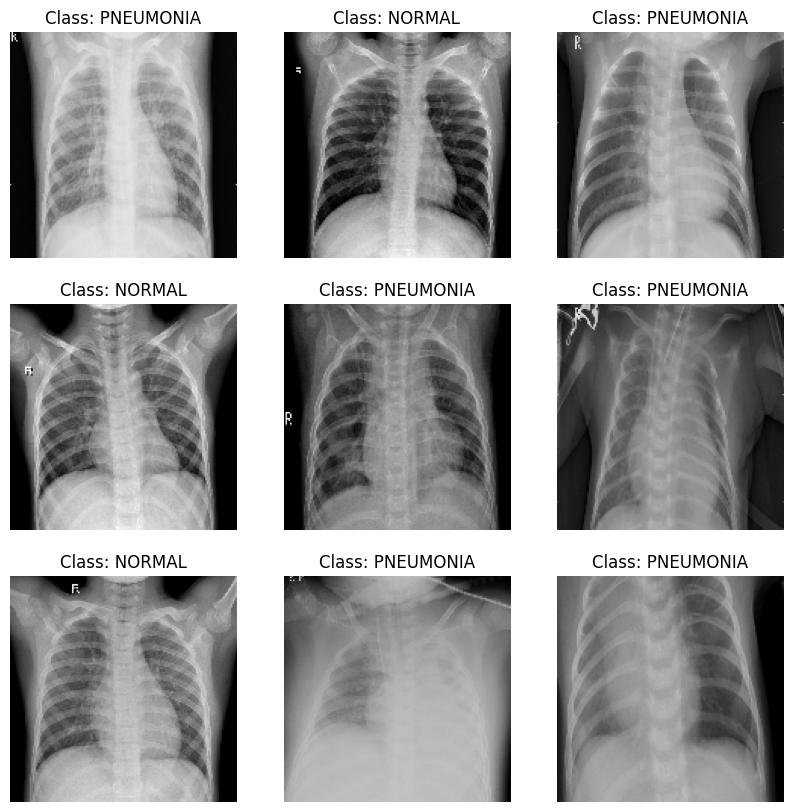

In [4]:
# --- 5. Visualize a Batch ---
plt.figure(figsize=(10, 10))

# Get one batch of images and labels from the training set
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # Set the title to the correct class name
        label_name = class_names[int(labels[i])]
        plt.title(f"Class: {label_name}")
        
        plt.axis("off")

plt.show()

In [5]:
# --- 6. Check for Class Imbalance ---
# This is a critical step, especially for medical data.
# Let's count the number of 0s (NORMAL) and 1s (PNEUMONIA) in our training set.

# We initialize a counter
label_counts = {0: 0, 1: 0}

# We have to loop through the dataset to count
# This is because the data is loaded in batches
for images, labels in train_ds:
    # 'labels' is a tensor of 32 (batch size) 0s and 1s
    for label in labels.numpy():
        label_int = int(label)
        if label_int in label_counts:
            label_counts[label_int] += 1

total_samples = sum(label_counts.values())
normal_count = label_counts[0]
pneumonia_count = label_counts[1]

print(f"--- Training Set Class Counts ---")
print(f"Total samples: {total_samples}")
print(f"Class 0 ({class_names[0]}): {normal_count} samples")
print(f"Class 1 ({class_names[1]}): {pneumonia_count} samples")

# Calculate percentages
if total_samples > 0:
    print(f"% NORMAL: {normal_count / total_samples * 100:.2f}%")
    print(f"% PNEUMONIA: {pneumonia_count / total_samples * 100:.2f}%")

C:\Users\naqsh\AppData\Local\Temp\ipykernel_12180\3686620635.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_int = int(label)


--- Training Set Class Counts ---
Total samples: 4186
Class 0 (NORMAL): 1080 samples
Class 1 (PNEUMONIA): 3106 samples
% NORMAL: 25.80%
% PNEUMONIA: 74.20%


In [6]:
# --- 7. Define Data Augmentation Layer ---
# This will "tweak" our training images (zoom, rotate, etc.)
# It helps the model generalize and prevents overfitting.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1), #
    tf.keras.layers.RandomZoom(0.1),
    # We add a rescaling layer here to normalize pixel values from [0, 255] to [0, 1]
    # This is critical for neural network performance.
    tf.keras.layers.Rescaling(1./255) 
])

# --- 8. Apply Augmentation & Performance Tuning ---

# For the TRAINING set:
# We apply augmentation AND we rescale the pixels.
# We also apply .cache() and .prefetch() for performance.
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# For the VALIDATION set:
# We must NOT augment the validation data. We only rescale it.
# We want to validate on the "real" images.
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# For the TEST set:
# Same as validation: only rescale.
test_ds = test_ds.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y), 
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nData augmentation layer created.")
print("Performance tuning (.cache() and .prefetch()) applied to all datasets.")
print("Pixel values rescaled to [0, 1].")


Data augmentation layer created.
Performance tuning (.cache() and .prefetch()) applied to all datasets.
Pixel values rescaled to [0, 1].


In [7]:
# --- 9. Calculate Class Weights to Handle Imbalance ---

# We already have these from the previous step:
# total_samples = 4186
# normal_count = 1080
# pneumonia_count = 3106

# The formula to balance the classes:
# Weight for class = (Total Samples / (Num Classes * Samples in Class))

num_classes = 2
weight_for_0_normal = (total_samples / (num_classes * normal_count))
weight_for_1_pneumonia = (total_samples / (num_classes * pneumonia_count))

# This is the dictionary we will pass to our model
class_weight_dict = {0: weight_for_0_normal, 1: weight_for_1_pneumonia}

print(f"Weight for Class 0 (NORMAL): {weight_for_0_normal:.2f}")
print(f"Weight for Class 1 (PNEUMONIA): {weight_for_1_pneumonia:.2f}")
print("\nThis tells the model to treat one 'NORMAL' sample as if it were ~1.94 samples.")

Weight for Class 0 (NORMAL): 1.94
Weight for Class 1 (PNEUMONIA): 0.67

This tells the model to treat one 'NORMAL' sample as if it were ~1.94 samples.


In [8]:
# --- 10. Build the CNN Model ---

IMG_SIZE = (150, 150) # Make sure this matches cell 1

model = tf.keras.Sequential([
    # Input layer must match our image shape
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    # --- Convolutional Block 1 ---
    # We are NOT rescaling here because our data pipeline (step 8)
    # is already doing it for us.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # --- Convolutional Block 2 ---
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # --- Convolutional Block 3 ---
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # --- Flatten and Dense Layers ---
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # Dropout is a regularization technique to prevent overfitting
    tf.keras.layers.Dropout(0.5), 
    
    # --- Output Layer ---
    # 1 neuron because this is binary (Normal/Pneumonia)
    # 'sigmoid' activation squashes the output to a probability (0 to 1)
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

# Print a summary of our model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- 11. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [10]:
# --- 12. Train the Model ---
# We will start with 15 epochs.
EPOCHS = 15 

print("Starting model training...")

# This is where the magic happens!
# We provide our training data, validation data, epochs,
# and most importantly, our class_weight_dict.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict 
)

print("Training finished.")

Starting model training...
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 685ms/step - accuracy: 0.6226 - loss: 0.6208 - precision: 0.8569 - recall: 0.5898 - val_accuracy: 0.7562 - val_loss: 0.5178 - val_precision: 1.0000 - val_recall: 0.7562
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 580ms/step - accuracy: 0.8411 - loss: 0.3608 - precision: 0.9466 - recall: 0.8329 - val_accuracy: 0.8289 - val_loss: 0.4237 - val_precision: 1.0000 - val_recall: 0.8289
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 575ms/step - accuracy: 0.8841 - loss: 0.2753 - precision: 0.9590 - recall: 0.8815 - val_accuracy: 0.8403 - val_loss: 0.4423 - val_precision: 1.0000 - val_recall: 0.8403
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 536ms/step - accuracy: 0.9171 - loss: 0.2079 - precision: 0.9729 - recall: 0.9137 - val_accuracy: 0.8614 - val_loss: 0.3856 - val_precision: 1.0000 - val_recall: 0.8614
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 649ms/step - accuracy: 0.9324 - loss: 0.1754 - precision: 0.9799 - recall: 0.

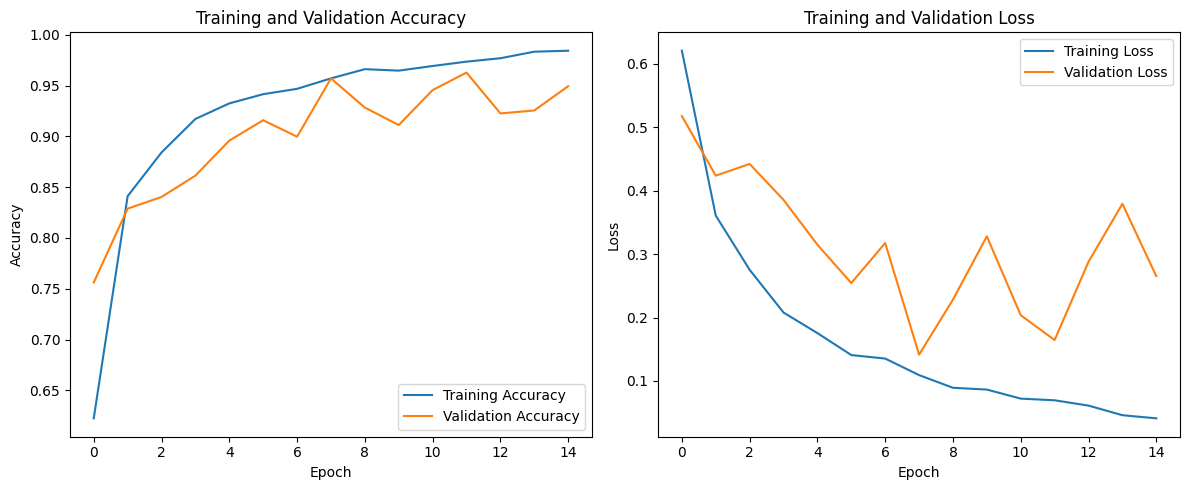

In [11]:
# --- 13. Plot Training & Validation History ---

# We'll plot Accuracy and Loss side-by-side
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [12]:
# --- 14. Evaluate on Test Data ---
# This gives us the final performance metrics on unseen data.
results = model.evaluate(test_ds)

print("\n--- Test Set Evaluation ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({(results[1]*100):.2f}%)")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.8269 - loss: 0.9603 - precision: 0.7987 - recall: 0.9667

--- Test Set Evaluation ---
Test Loss: 0.9603
Test Accuracy: 0.8269 (82.69%)
Test Precision: 0.7987
Test Recall: 0.9667


In [13]:
# --- 15. Load the Pre-Trained Base Model (MobileNetV2) ---
IMG_SIZE = (150, 150) # Make sure this is still (150, 150)

# 1. Load the base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,  # Don't include the 1000-class classifier
    weights='imagenet'  # Use the pre-trained weights
)

# 2. Freeze the base model
# We don't want to re-train all those millions of parameters
base_model.trainable = False

# 3. Print a summary of our new "expert" body
print("--- Base Model Summary (MobileNetV2) ---")
base_model.summary()

C:\Users\naqsh\AppData\Local\Temp\ipykernel_12180\1445788443.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
--- Base Model Summary (MobileNetV2) ---


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# --- 16. Build Our New Model ("Head") on Top ---

model_v2 = tf.keras.Sequential([
    # 1. The 'body': Our frozen, expert base model
    base_model,
    
    # 2. The 'bridge': This pools the features from the base model
    tf.keras.layers.GlobalAveragePooling2D(),
    
    # 3. The 'head': Our new, trainable classifier
    # We add a Dropout layer for safety, to prevent overfitting
    tf.keras.layers.Dropout(0.5),
    
    # 4. The 'output': Our final sigmoid neuron
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

# 4. Print the summary of our *full* new model
print("\n--- Full Model V2 (Base + Head) Summary ---")
model_v2.summary()


--- Full Model V2 (Base + Head) Summary ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# --- 17. Compile the V2 Model ---
# We use the exact same compile settings
model_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# --- 18. Train the V2 Model ---
# This should train much faster and be more stable.
# We'll use 10 epochs, which should be plenty for this new head to learn.
EPOCHS_V2 = 10 

print("\nStarting V2 model training...")

# Notice we use our new model 'model_v2' and a new history 'history_v2'
history_v2 = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_V2,
    class_weight=class_weight_dict # We STILL need this!
)

print("V2 training finished.")


Starting V2 model training...
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 458ms/step - accuracy: 0.7511 - loss: 0.5230 - precision: 0.8972 - recall: 0.7505 - val_accuracy: 0.8901 - val_loss: 0.2878 - val_precision: 1.0000 - val_recall: 0.8901
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.8593 - loss: 0.3310 - precision: 0.9477 - recall: 0.8577 - val_accuracy: 0.9044 - val_loss: 0.2465 - val_precision: 1.0000 - val_recall: 0.9044
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.8772 - loss: 0.2812 - precision: 0.9586 - recall: 0.8722 - val_accuracy: 0.8824 - val_loss: 0.2848 - val_precision: 1.0000 - val_recall: 0.8824
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 406ms/step - accuracy: 0.8932 - loss: 0.2595 - precision: 0.9628 - recall: 0.8905 - val_accuracy: 0.8795 - val_loss: 0.2900 - val_precision: 1.0000 - val_recall: 0.8795
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 429ms/step - accuracy: 0.8966 - loss: 0.2417 - precision: 0.9658 - recall

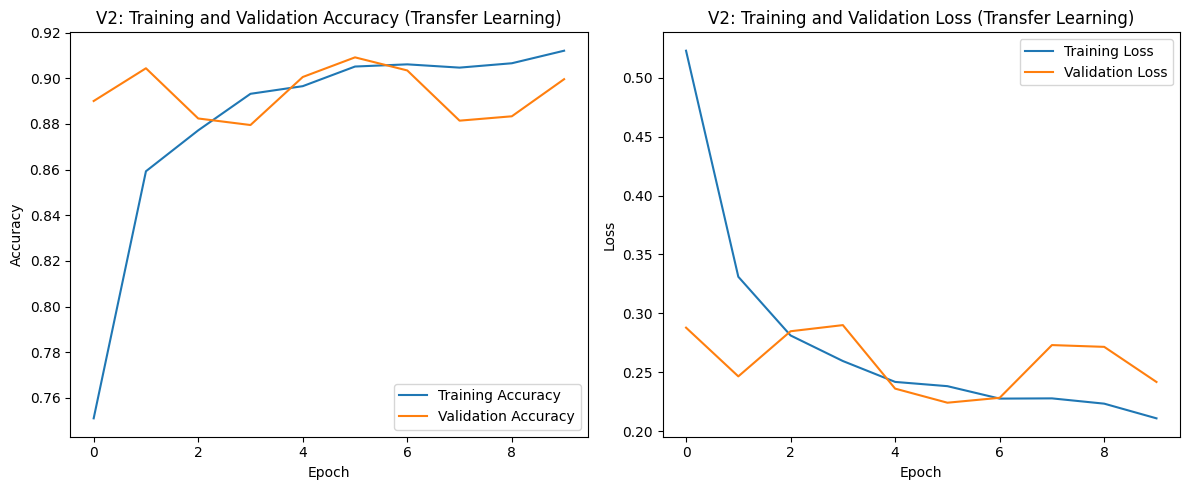

In [16]:
# --- 19. Plot V2 Training & Validation History ---

# Get the data from our new history object
acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

# Get the number of epochs we ran
epochs_range_v2 = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range_v2, acc, label='Training Accuracy')
plt.plot(epochs_range_v2, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('V2: Training and Validation Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_v2, loss, label='Training Loss')
plt.plot(epochs_range_v2, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('V2: Training and Validation Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [17]:
# --- 20. Evaluate V2 on Test Data ---

print("\n--- V2 Test Set Evaluation (Transfer Learning) ---")
results_v2 = model_v2.evaluate(test_ds)

print(f"V2 Test Loss: {results_v2[0]:.4f}")
print(f"V2 Test Accuracy: {results_v2[1]:.4f} ({(results_v2[1]*100):.2f}%)")
print(f"V2 Test Precision: {results_v2[2]:.4f}")
print(f"V2 Test Recall: {results_v2[3]:.4f}")

print("\n--- V1 (Original) Results for Comparison ---")
print(f"V1 Test Loss: 0.9603")
print(f"V1 Test Accuracy: 0.8269 (82.69%)")
print(f"V1 Test Precision: 0.7987")
print(f"V1 Test Recall: 0.9667")


--- V2 Test Set Evaluation (Transfer Learning) ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy: 0.8990 - loss: 0.2657 - precision: 0.8921 - recall: 0.9538
V2 Test Loss: 0.2657
V2 Test Accuracy: 0.8990 (89.90%)
V2 Test Precision: 0.8921
V2 Test Recall: 0.9538

--- V1 (Original) Results for Comparison ---
V1 Test Loss: 0.9603
V1 Test Accuracy: 0.8269 (82.69%)
V1 Test Precision: 0.7987
V1 Test Recall: 0.9667


In [18]:
# --- 21. Save the Final Model ---

# Define a name for our winning model
model_filename = 'pneumonia_detector_v2.keras'

model_v2.save(model_filename)

print(f"Model saved successfully as '{model_filename}'")

Model saved successfully as 'pneumonia_detector_v2.keras'


In [ ]:
hb